In this notebook, we will use [dual state verification](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.022427) to mitigate incoherent errors arrising in quantum circuits. Moroever, we will see that adding dynamical decoupling and pauli twirling, that turns coherent into incoherent errors, improves virtual distillation. 

# The physical system
We will start by defining the hamiltonian we wish to simulate, the backend and different useful parameters. We will consider a Heisenberg chain with closed boundary condition on $N$ qubits. 
<center>
$H = J\sum_{n=0}^{{N-1}} X_nX_{n+1} +  Y_nY_{n+1} + \Delta Z_nZ_{n+1}$, 

where $X_n, Y_n, Z_n$ are the corresponding Pauli matrices acting on the $n$-th qubit. For an inital state $|\psi\rangle$ and observable $O$, we wish to compute 
 <center>    
$\langle\psi| e^{iHt}Oe^{-iHt}| \psi\rangle$, for $t = \tau n$, 
    </p>
        
where $n$ is the number of Trotter step and $\tau$ some fixed evolution time. We then wish to implement a first order Trotterization with $n$ steps. Note that the time evolution can be performed with only linear connnectivity, which makes it a useful benchmark for IBM quantum hardware.

# Dual state verification
In a nutshell, [dual state verification](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.022427) (DSV) works as [virtual distillation](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041036), which uses multiples copies to suppress the non dominant component exponentially fast. However virtual distillation requires a connectivity between every copies and is therefore challenging to implement on IBMQ hardware in the near term. Instead, DSV uses only two copies, one at the beginning to simulate the evolution and one at the end of the circuit to verify the execution. The expectation value is then computed via projection on an ancillary qubit, similarly as a swap test. For simplicity, we require the measured observable to be $Z_1 = Z_1 \otimes_{i=2}^N \mathbb{1}_i$. If this is not the case, we can apply a transformation $B$ such that $BOB^\dagger=Z_1$, which is refered as conversion in the following picture.

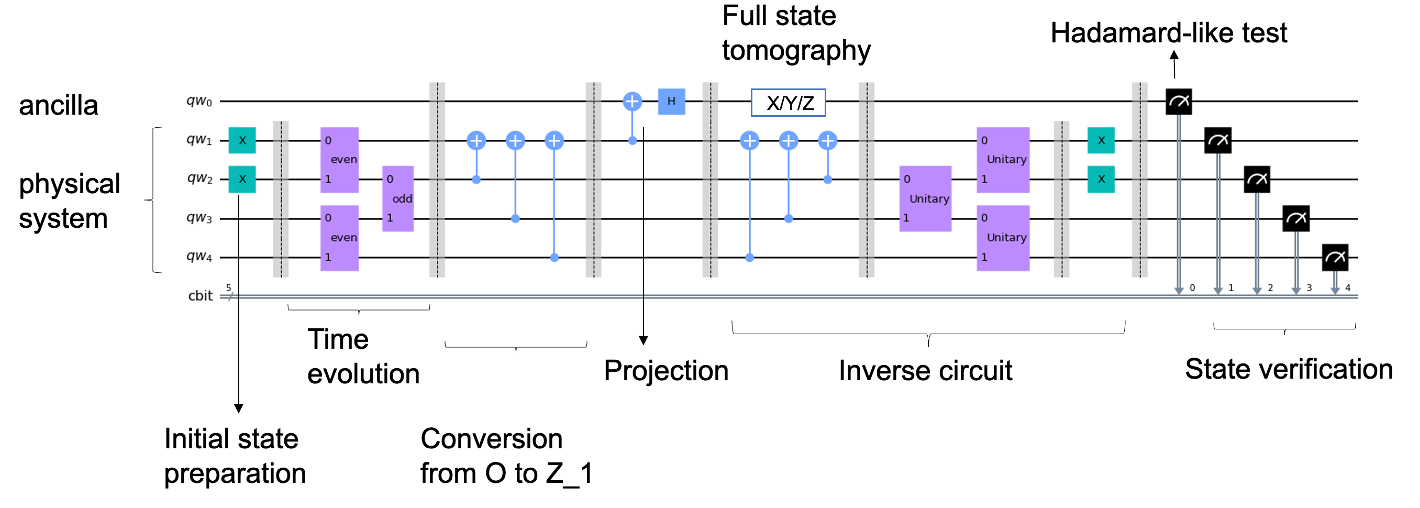

In [1]:
from IPython.display import Image
Image("DSV.png")


In essence, the full scheme include a initial state preparation, forward time simulation, transformation of the observable to $Z_1$ via $B$, backward evolution of the bulk system and state verification via measuring how far away the final state is from $|0\rangle^{\otimes N}$, which should be obtained without noise. The expectation value of the observable is computed via a projection on the ancilla. In the case displayed above, we consider $O=\otimes_{i=1}^N Z_i$, which requires the largest overhead from the transformation map $B$. We note that in the remaning of this notebook we will use $O=Z_1\otimes Z_2 \otimes \mathcal{I}_{N-2}$ which requires minimal overhead. Analytical calculations show that in the noise free case, the ancilla should be pure. Hence, we can purify the ancilla by performaing full state tomography (which requires 3 measurements in the three different basis X,Y and Z) and keep only the eigenstate with the largest eigenvalue. We will refer to this technique as purified dual state verification.

## Construction of the quantum circuits

In [1]:
from qiskit.opflow import X,Y,Z,I 
from qiskit import QuantumCircuit
import qiskit
import scipy.linalg
import numpy as np
import time

# Let's define the size and coefficient of the chain
N = 6   #number of spin
J = np.arctan(0.5)
delta = 1 

#Let's define the observable we wish to measure

observable = (I^(N-2))^Z^Z
print('O = ', observable)


# Let's define the initial state
psi = QuantumCircuit(N)
for n in range(N//2):
    psi.x(n)
    


# Pauli matrices
X = [[0, 1], [1, 0]]
Y = [[0, -1j], [1j, 0]]
Z = [[1, 0], [0, -1]]
I = [[1, 0], [0, 1]]

def construct_circuit(num_qubit, J, delta, step, psi):
    """
    Constructs circuits for the Trotter-evolved XXZ Hamiltonian.

    args
    num_qubit : int
        Number of spins in the spin chain
    lam : float
        lam relates to the spin-spin coupling J = atan(lam)/2
    delta : float
        delta is the anisotropy of the XXZ model, where 0 < delta < 1 is the easy-axis XXZ model (ballistic spin transport),
        delta = 1 is the XXX model (superdiffusive), and delta > 1 is the easy-plane XXZ (diffusive)
    step : int
        Number of Trotter steps. Each time step comprises an "odd" and "even" layer of two-qubit coupling gates.

    returns
    qc : QuantumCircuit
        A list of quantum circuits for time = [0, steps]
    """
    qc = QuantumCircuit(num_qubit)

    # Hard domain wall initial state
    # Qubits 0 to num_qubit/2 - 1 are up, and qubits num_qubit/2 to num_qubit - 1 are down
    
    qc.append(psi,range(num_qubit))

    # Time evolution for t steps
        
    # Time evolution operator U = exp(-iHt) trotterized to first order
    U = scipy.linalg.expm(1j * J * (np.kron(X, X) + np.kron(Y, Y) + delta * np.kron(Z, Z)))
    for _ in range(step):
        for even_qubit in range(0, num_qubit, 2):
            qc.unitary(U, (even_qubit, even_qubit+1), label='even')
        for odd_qubit in range(1, num_qubit-1, 2):
            qc.unitary(U, (odd_qubit, odd_qubit+1), label='odd')

   

    return qc



O =  IIIIZZ


In [2]:
# Let's import the backend 
from qiskit import QuantumCircuit, IBMQ, execute, Aer, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.utils import QuantumInstance
from qiskit.opflow.expectations  import PauliExpectation
from qiskit.opflow import CircuitStateFn, StateFn, CircuitSampler
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeVigo, FakeMumbai

# Parameters of the circuit executions
shots = 100000
backend_ideal = QasmSimulator() # Noiseless (target)
backend_noisy = AerSimulator.from_backend(FakeMumbai()) # Noisy simulations

IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-cern", group="internal", project="born-machine")
backend_real = provider.get_backend('ibmq_mumbai')

initial_layout = [0,1,4,7,10,12,15] # we need N+1 qubit to take into account the ancilla

For simplity, we will only perform experiments on the noisy simulator FakeMumbai, and compare with noiseless experiemnts at fixed number of shots 100k. We will perform 10 experiments to collect statictics.

# Stochastic compilation

Now that we have defined the circuit we wish to execute, we will set up the error mitigation scheme. On top of dual state verification (DSV), implemented in the corresponding python class, we will add [dynamical decoupling](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.DynamicalDecoupling.html), which insert identy gates when the qubits are idling, leading to longer coherence time, and [pauli twirling](https://www.nature.com/articles/s41598-019-46722-7), that insert pauli gate conjugation at random places, effectively turning coherent to incoherent noise. The number of random insertion is denoted with the variable 'num_twirls'. We will also allow [pulse efficient transpilation](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088) (pe), that optimize the pulse sequences required to run the circuit on IBMQ superconduncting quantum hardware. Dynamical decoupling is important on the ancilla which is idling for a long time. Moreover, twirling has a synergy with dual state verification, which focuses on suppressing incoherent errors, since it transforms coherent errors into incoherent ones. From experience, we will assume 'XY8' is the best  dynamical decoupling sequence and that 15 twirling samples is enough for this use case. 

## Dynamical decoupling
In the following picture, we can see the insertion of a 'XX2' sequences on qubit 0 and 1, which are idling for the second half of the circuit. 


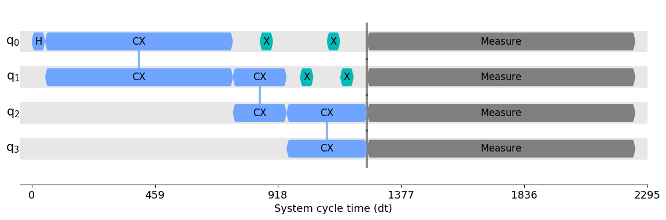

In [90]:
Image("dd.png")

## Pauli Twirling
Essentially, twirling conjugates the gate of interst with a sequences of gates, that preserve the state. For instance, we will look at the following [example](https://link.springer.com/article/10.1140/epjp/s13360-020-00360-5), where the gate of interest is a CNOT gate. We note, that if we consider pauli twirling (i.e. where the conjugation gates are Pauli matrices), we obtain 16 possible gate sequences, as displayed in (b). 

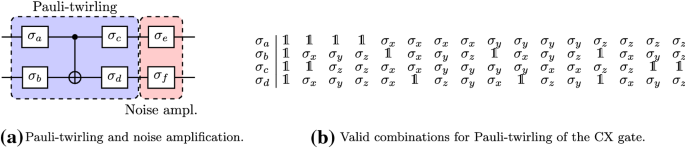

In [91]:
Image('twirling.png')

## Choice of the parameters

In [3]:
step = 10
dynamical_decoupling = None # sequence for dynamical decoupling, can be None, X2, Y2, XY2, XX8, YY8 or XY8 
num_twirls = 0              # number of randomized pauli twirling 
pe = False                  # pulse efficient compilation 
mem = False                 # measurement error mitigation, according to Nation, et al., PRX Quantum 2, 040326 (2021) 



In [4]:
#Let's construct the raw and dual state verified circuits

from dual_state_verification import Dual_state_verification

DSV = Dual_state_verification()
DSV._step = step

expectation_ideal = []
expectation = [[],[],[]]
        
qc_list = []
qc_raw = []
measured_operator = observable.primitive[::-1]
measured_operator = [str(measured_operator)]  #inverse ordering in the circuit construction since ancilla is qubit 0

for i in range(1,step+1):

    qc_origin = construct_circuit(N, J, delta, i, psi)

    # let's save the raw circuit for comparison

    qc_origin_copy = qc_origin.copy()
    qc_origin_copy.measure_all()
    qc_origin_copy = qiskit.transpile(qc_origin_copy, backend = backend_real, initial_layout = initial_layout[len(initial_layout)-N:])
    qc_raw.append(qc_origin_copy)

    # let s run the noiseless benchmark 
    q_instance = QuantumInstance(backend_ideal,shots = shots)

    circ = qiskit.transpile(qc_origin,basis_gates=['rz','sx','cx'])
    
    expectation_ = StateFn(observable, is_measurement=True) @ StateFn(circ)
    expectation_ = PauliExpectation().convert(expectation_)
    sampler = CircuitSampler(q_instance).convert(expectation_)
    expectation_ideal.append(sampler.eval().real)
       
    # full state tomography 
    for anc_op in ['X', 'Y', 'Z']: # We need three virtual distillation circuits per circuit for full ancilla tomography to purify the ancilla
        qc_list.append(DSV.prepare_vd_circuit_arbitrary(qc_origin, measured_operator, False,anc_op))
    

  
print(expectation_ideal)
qc_list[0].draw()

[0.17577999999999994, -0.013380000000000059, -0.053599999999999995, -0.02193999999999996, 0.14310000000000003, 0.24266000000000007, 0.42766000000000004, 0.61038, 0.4248000000000002, 0.32796]


░       ░    ┌───┐       ┌───┐    »
q44_0: ─────────────────────────────────░───────░────┤ X ├───────┤ H ├────»
       ┌─────────────┐┌───────┐         ░ ┌───┐ ░    └─┬─┘       ├───┤    »
q44_1: ┤0            ├┤0      ├─────────░─┤ X ├─░──────■─────────┤ X ├────»
       │             ││  even │┌──────┐ ░ └─┬─┘ ░                └─┬─┘    »
q44_2: ┤1            ├┤1      ├┤0     ├─░───■───░──────────────────■──────»
       │             │├───────┤│  odd │ ░       ░                         »
q44_3: ┤2            ├┤0      ├┤1     ├─░───────░─────────────────────────»
       │  circuit-85 ││  even │├──────┤ ░       ░ ┌──────────┐            »
q44_4: ┤3            ├┤1      ├┤0     ├─░───────░─┤0         ├────────────»
       │             │├───────┤│  odd │ ░       ░ │  Unitary │┌──────────┐»
q44_5: ┤4            ├┤0      ├┤1     ├─░───────░─┤1         ├┤0         ├»
       │             ││  even │└──────┘ ░       ░ └──────────┘│  Unitary │»
q44_6: ┤5            ├┤1      ├─────────░───────░─────────────┤1         ├»
       └─────────────┘└───────┘         ░       ░             └──────────┘»
 c1: 7/═══════════════════════════════════════════════════════════════════»
                                                                          »
«                   ┌─┐                                                
«q44_0: ────────────┤M├────────────────────────────────────────────────
«                   └╥┘┌──────────┐┌────────────────┐┌─┐               
«q44_1: ─────────────╫─┤0         ├┤0               ├┤M├───────────────
«       ┌──────────┐ ║ │  Unitary ││                │└╥┘┌─┐            
«q44_2: ┤0         ├─╫─┤1         ├┤1               ├─╫─┤M├────────────
«       │  Unitary │ ║ ├──────────┤│                │ ║ └╥┘┌─┐         
«q44_3: ┤1         ├─╫─┤0         ├┤2               ├─╫──╫─┤M├─────────
«       └──────────┘ ║ │  Unitary ││  circuit-85_dg │ ║  ║ └╥┘┌─┐      
«q44_4: ─────────────╫─┤1         ├┤3               ├─╫──╫──╫─┤M├──────
«                    ║ └──────────┘│                │ ║  ║  ║ └╥┘┌─┐   
«q44_5: ─────────────╫─────────────┤4               ├─╫──╫──╫──╫─┤M├───
«                    ║             │                │ ║  ║  ║  ║ └╥┘┌─┐
«q44_6: ─────────────╫─────────────┤5               ├─╫──╫──╫──╫──╫─┤M├
«                    ║             └────────────────┘ ║  ║  ║  ║  ║ └╥┘
« c1: 7/═════════════╩════════════════════════════════╩══╩══╩══╩══╩══╩═
«                    0                                1  2  3  4  5  6

In [5]:
import matplotlib.pyplot as plt
def plot(expectation,purity):
    
    # expectation: [[experiements 1], [experiemnts 2]]
    # experiemnts 1 = [sub exp1, sub exp2, ...]
    
    step = len(purity[0][0][0])
    fig, axes = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
    color = ['g','b','r']
    mod = ''

    axes[0].plot(range(1,step+1),expectation_ideal,'k-',label='ideal')
    symbol = '.--'
    for s, exp in enumerate(expectation):
        if s>0:
            symbol = '.-'
            mod = ' (dd_twirled)'
        mean = np.mean(exp,axis=0)
        var = np.std(exp,axis=0)
        label='raw'
        for j in range(3):
            if j ==1:
                label = 'DSV'
            elif j==2:
                label='DSV_purified'
            axes[0].errorbar(range(1,step+1),mean[j],yerr=var[j],color=color[j],fmt =symbol,label=label+mod)
        
        
    axes[0].legend()
    axes[0].set_ylabel(r'$\langle O \rangle$')
    axes[0].set_xlabel('Trotter steps')
    
    symbol = '.--'
    mod = ''
    axes[1].set_title('purity of the ancilla qubit')
    for s, exp in enumerate(purity):
        if s>0:
            symbol = '.-'
            mod = 'dd_twirled'
        mean = np.mean(exp,axis=0)
        var = np.std(exp,axis=0)
        
        axes[1].errorbar(range(1,step+1),mean[0],yerr=var[0],fmt='r'+symbol,label='DSV_purified'+mod)
    axes[1].set_xlabel('Trotter steps')

    plt.savefig('DSV_experiment.png')
    plt.show()

# DSV and circuit execution
Now that we have our circuits, we need to transpile them using the different compilation methods listed above and run them on the chosen backend. The counts are then post processed using the DSV class to output the expectation value, composed of three list (raw, DSV, purified DSV) and the purity of the ancilla qubit obtained through full tomography. We expect the purity to be close to 1. This is the reason ancilla purification is important. We will plot the ancilla purity as a function of the number of Trotter steps and observe that the performance of DSV deteriorates with the purity. 

For the first test, we will only run on the noisy simulator FakeMumbai, and we will try the real hardware later

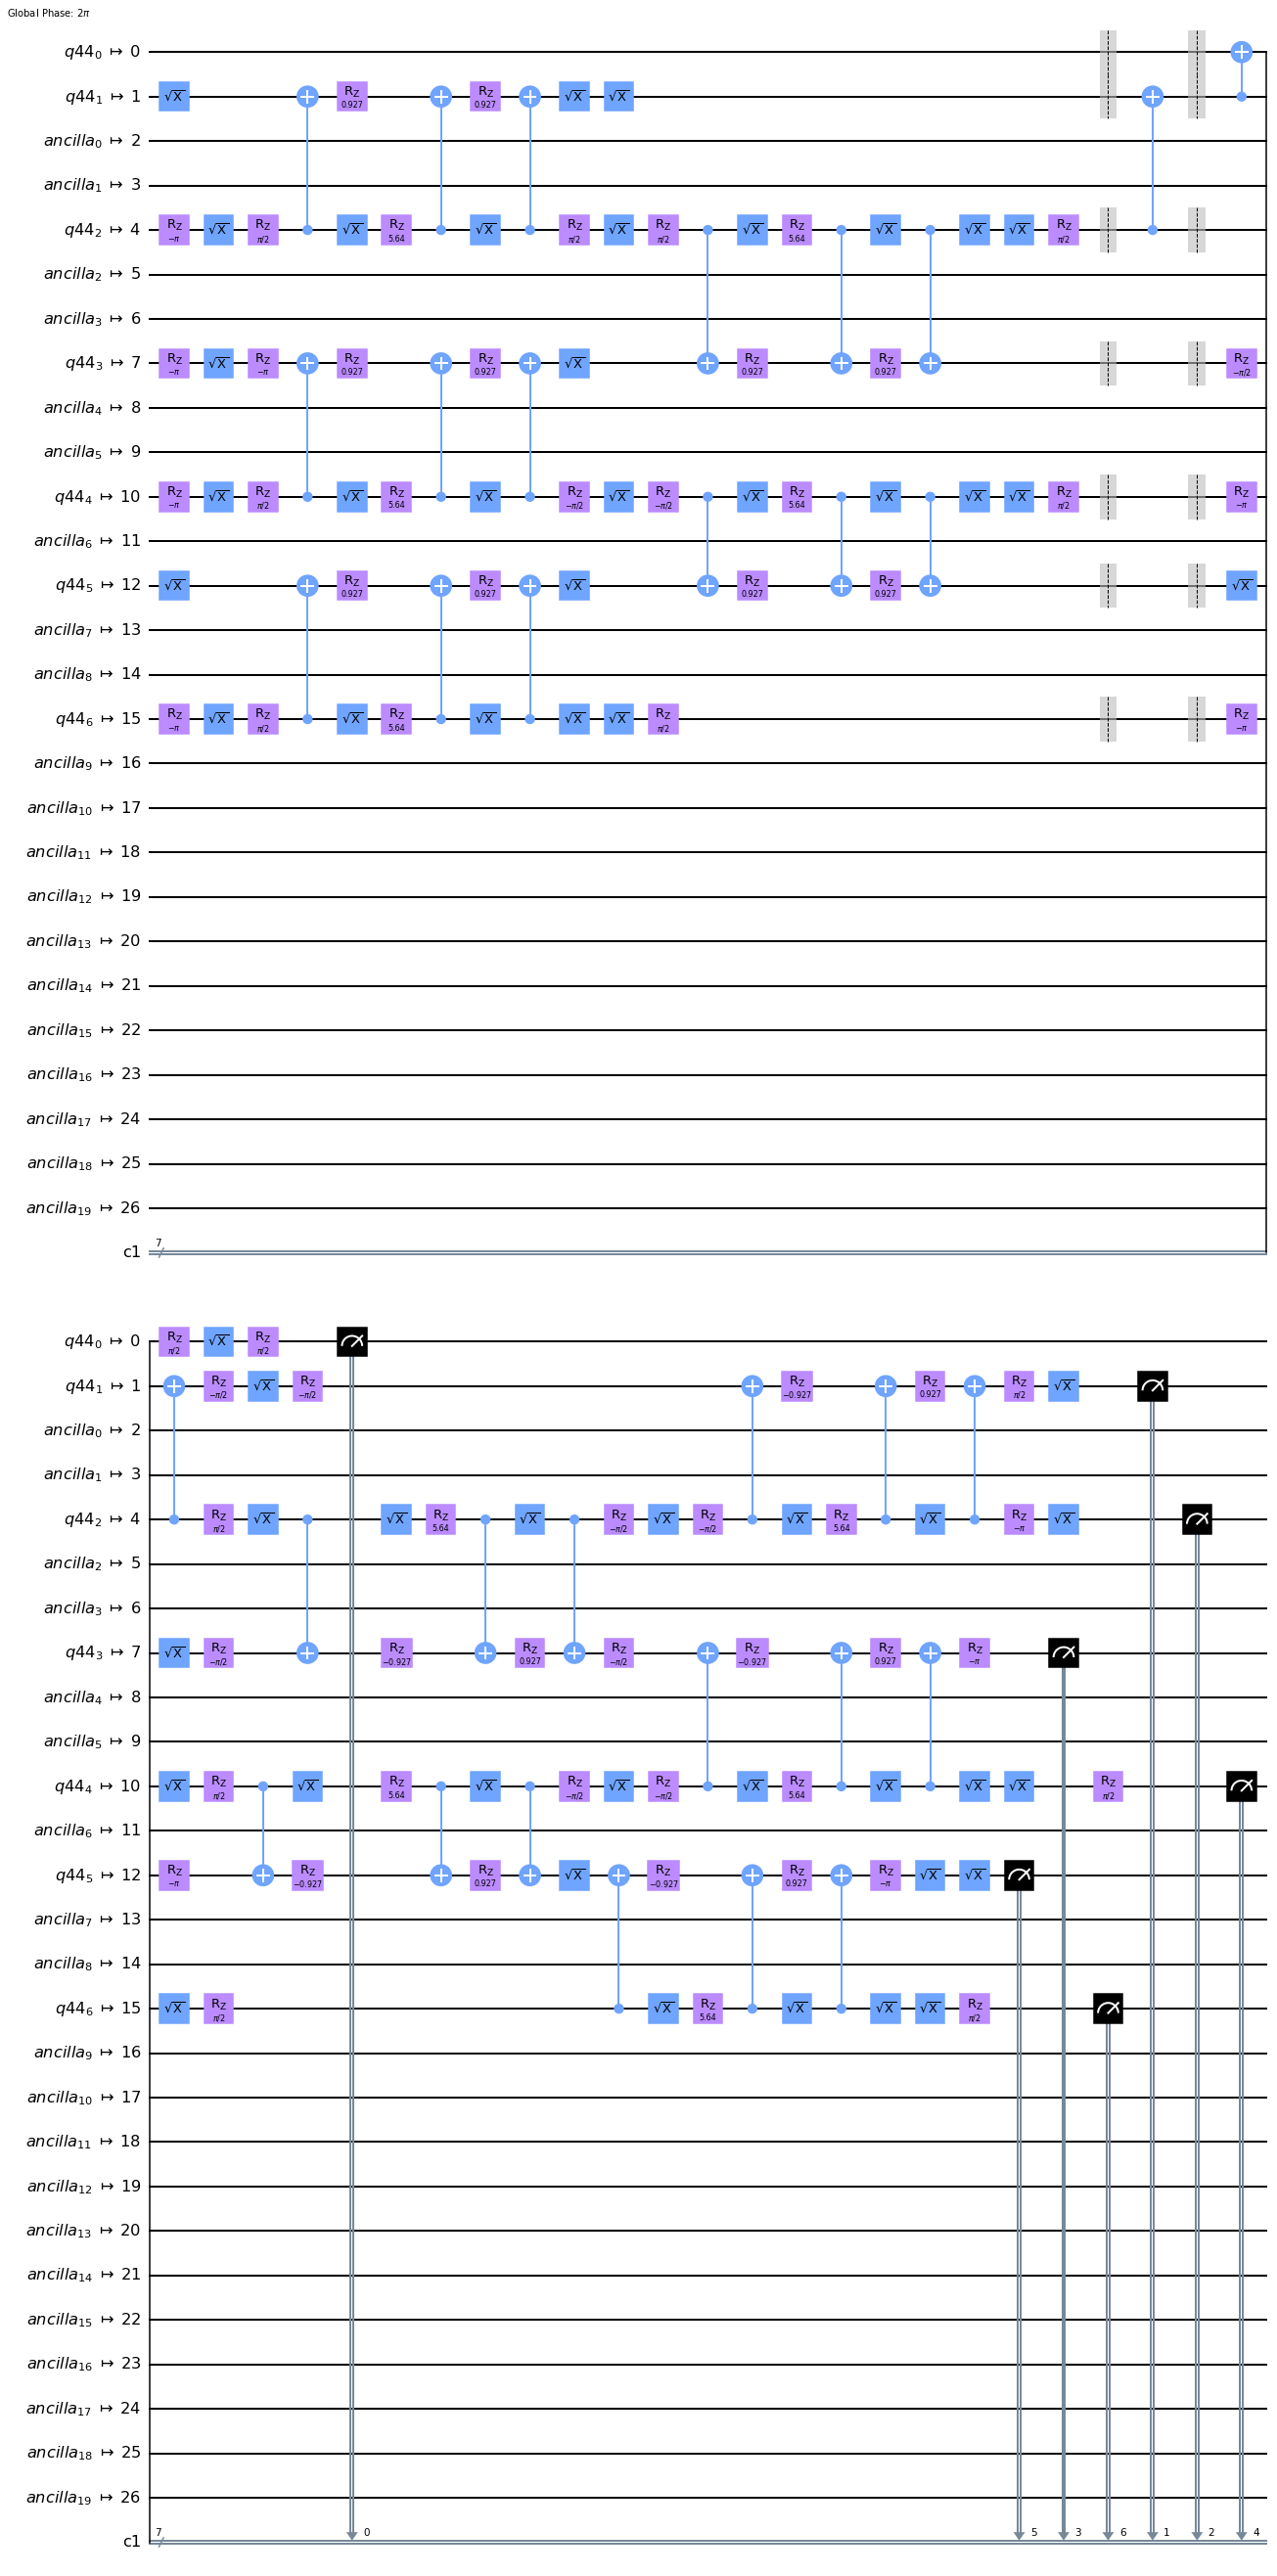

In [6]:
qc_transpiled = DSV.transpile(qc_list, backend = backend_real, initial_layout = initial_layout, 
                              num_twirls = 0, dynamical_decoupling= None, 
                              optimization_level = 3, seed = 17245)


qc_transpiled = qc_raw + qc_transpiled
qc_transpiled[step].draw('mpl')


In [7]:
job = qiskit.execute(qc_transpiled,backend = backend_noisy, shots=shots)

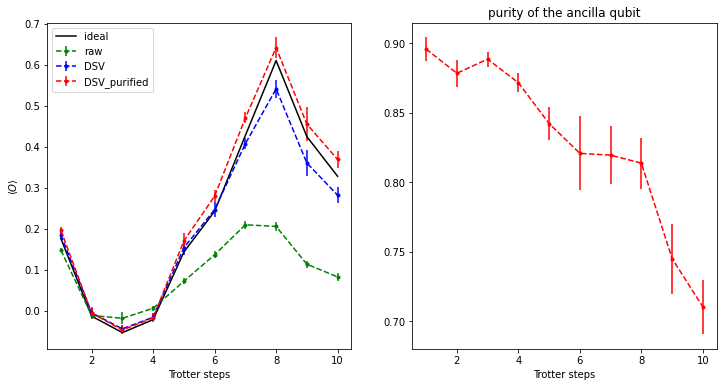

In [8]:

counts = job.result().get_counts()
counts = DSV.post_process(counts,split=10) #split the jobs into smaller experiments to collect statistics
expectation,purity = DSV.compute_expectation_value(counts, measured_operator)

plot([expectation],[purity])

In [ ]:
#Let's run the job on the real hardware
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(qc_transpiled, backend=backend_real, shots = shots, name='DSV')
job_set_id = job_set_foo.job_set_id()

print('job id:', job_set_id)
time.sleep(30)
print(job_set_foo.statuses())


In [ ]:
# real hardware 
counts = [] 
retrieved_foo = job_manager.retrieve_job_set(job_set_id=job_set_id, provider=provider)
for i in range(1000): #we loop over more than the total of experiements
    try:
        counts.append(retrieved_foo.results().get_counts(i))
    except:
        # we have collected everything 
        break

counts = DSV.post_process(counts,split=5) #split the jobs into smaller experiments to collect statistics

expectation,purity = DSV.compute_expectation_value(counts, measured_operator)

plot([expectation],[purity])

# Let's play with dynamical decoupling and twirling! 

Let's go on real hardware

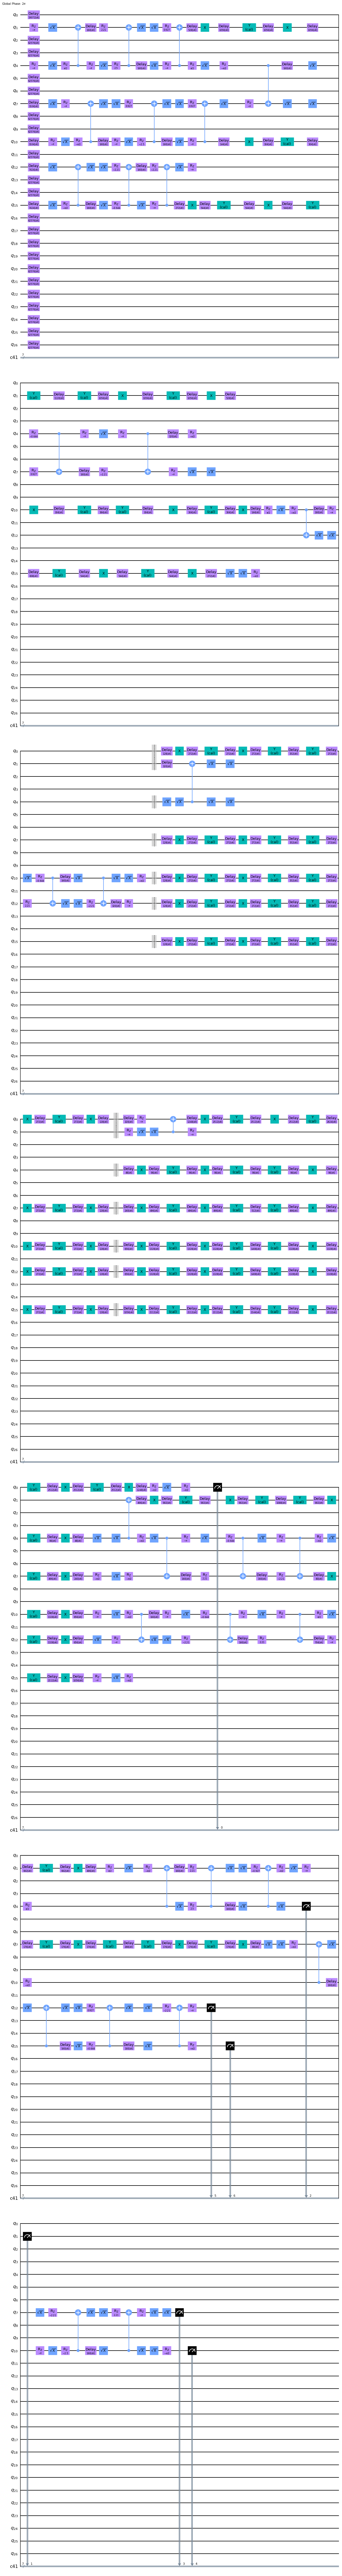

In [14]:
num_twirls = 10
dynamical_decoupling = 'XY8'



qc_transpiled = DSV.transpile(qc_list, backend = backend_real, initial_layout = initial_layout,
                              num_twirls = num_twirls,
                              dynamical_decoupling = dynamical_decoupling, 
                              optimization_level = 3, seed = 17245)
qc_transpiled = qc_raw + qc_transpiled

job = qiskit.execute(qc_transpiled,backend = backend_noisy, shots=shots)

qc_transpiled[step+1].draw('mpl')

In [18]:
job_set_id = '90504285bec54a1e927b34ea0addc075-16700178827857652'


In [10]:
#Let's run the job on the real hardware
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(qc_transpiled, backend=backend_real, shots = shots, name='DSV')
job_set_id_dd = job_set_foo.job_set_id()

print('job id:', job_set_id)
time.sleep(30)
print(job_set_foo.statuses())

job id: fa5713ee46da43c0b630b21c0ac7c89d-16700061000280619


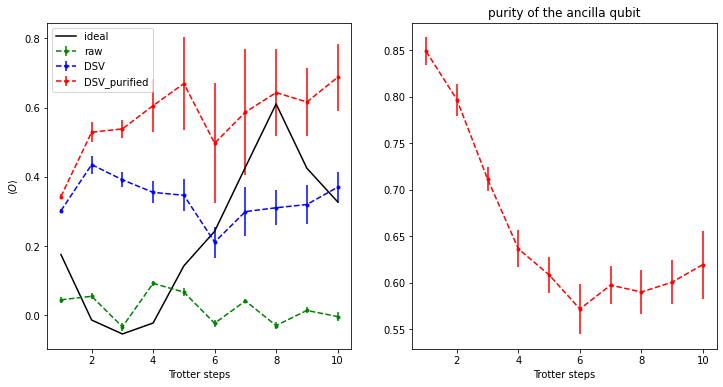

In [20]:
# real hardware 
counts = [] 
DSV._num_twirls = 0
retrieved_foo = job_manager.retrieve_job_set(job_set_id=job_set_id, provider=provider)
for i in range(1000): #we loop over more than the total of experiements
    try:
        counts.append(retrieved_foo.results().get_counts(i))
    except:
        # we have collected everything 
        break

counts = DSV.post_process(counts,split=10) #split the jobs into smaller experiments to collect statistics

expectation_dd,purity_dd = DSV.compute_expectation_value(counts, measured_operator)

plot([expectation_dd],[purity_dd])